In [131]:
#Importing csv in a data frame and removing garbage last row AND adding current year to a variable
from datetime import date
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


year_ = int(date.today().year)
df = pd.read_csv("orders.csv", delimiter = '|', low_memory=False, encoding = 'ISO-8859-1', header=None, skiprows=[0])
df.columns = ['Customer_number', 'Age', 'Gender', 'PoR', 'Order_number', 'Order_date', 'Product_number', 'Sub_category', 'Category', 'Count', 'Price', 'Expected_delivery_time', 'Actual_delivery_time', 'Reason_of_return', 'Rating', 'Trash']
df['Gender'] = (df['Gender'] !='Man').astype(int)

df.Age = df.Age.str.slice(0,4)
df.Age = pd.to_numeric(df.Age)
df.Age = year_ - df.Age

del df['Trash']
df['order_total'] = df.Price*df.Count

def clean_productnumber(productnumber_column):
    productnumber_column = productnumber_column.str.replace('O', '0', regex=True)
    productnumber_column = productnumber_column.str.replace('l', '1', regex=True)
    return productnumber_column

df['Product_number_numeric'] = clean_productnumber(df['Product_number'])

df.Reason_of_return = df.Reason_of_return.fillna(value=0)
df['Returned'] = df.Reason_of_return.apply(lambda x: True if x != 0 else False)

# df['Not_Delivered'] = df.apply(lambda x: True if (x['Actual_delivery_time'] == -1 & x['Returned'] == False) else False, axis=1)

df['ReasonOfReturn'] = df['Reason_of_return'].map({"Don't like the article": 0, 'Wrong or missing article': 1,
       'Disapointing quality': 2, 'Article is defect': 3,np.nan: -1,
       "Doesn't meet expectations": 5, 'No reason given': 6,
       'Article seems different than online': 7, 'Delivery took to long': 8,
       'Damaged package': 9, 'Manufacturing error': 10,
       'Ordered the wrong article by accident': 11})

df['ReasonOfReturn'].fillna(-1, inplace = True)

df['Order_date'] = pd.to_datetime(df['Order_date'])

In [397]:
global_stats = df.groupby(df['Order_date'].dt.date)['Count'].sum()
global_stats.plot(figsize=(20,10))

In [398]:
global_stats = global_stats.reset_index()

In [399]:
def create_lags(df, N, lag_column):
    df['Order_date'] = pd.to_datetime(df['Order_date'])
    df = df.sort_values(by='Order_date')
    df[lag_column] = np.sqrt( df[lag_column])
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    for i in range(N):
        df['Lag' + str(i+1)] = pd.Series(np.sqrt(df[lag_column].shift(i+1)))
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [400]:
global_stats_lags = create_lags(global_stats,50, 'Count')

In [401]:
global_stats_features = global_stats_lags.iloc[:, 2:]
global_stats_target = global_stats_lags.iloc[:, 0]

In [402]:
global_stats_features

Lag1    Lag2    Lag3    Lag4    Lag5    Lag6    Lag7    Lag8    Lag9  \
0      468.0  1070.0  1194.0  1693.0  2755.0   467.0  1852.0  1474.0   854.0   
1     2454.0   468.0  1070.0  1194.0  1693.0  2755.0   467.0  1852.0  1474.0   
2     2712.0  2454.0   468.0  1070.0  1194.0  1693.0  2755.0   467.0  1852.0   
3     1532.0  2712.0  2454.0   468.0  1070.0  1194.0  1693.0  2755.0   467.0   
4      900.0  1532.0  2712.0  2454.0   468.0  1070.0  1194.0  1693.0  2755.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1771  1126.0  2174.0  3213.0  3471.0  2530.0   855.0  1845.0  2723.0   442.0   
1772  1690.0  1126.0  2174.0  3213.0  3471.0  2530.0   855.0  1845.0  2723.0   
1773  1248.0  1690.0  1126.0  2174.0  3213.0  3471.0  2530.0   855.0  1845.0   
1774  2475.0  1248.0  1690.0  1126.0  2174.0  3213.0  3471.0  2530.0   855.0   
1775  1270.0  2475.0  1248.0  1690.0  1126.0  2174.0  3213.0  3471.0  2530.0   

       Lag10  ...   Lag41   Lag42   Lag43   Lag44   Lag45   Lag46   Lag47  \
0      874.0  ...  1212.0   930.0  4969.0  3953.0   630.0  2324.0  1788.0   
1      854.0  ...  2538.0  1212.0   930.0  4969.0  3953.0   630.0  2324.0   
2     1474.0  ...  2546.0  2538.0  1212.0   930.0  4969.0  3953.0   630.0   
3     1852.0  ...   683.0  2546.0  2538.0  1212.0   930.0  4969.0  3953.0   
4      467.0  ...   583.0   683.0  2546.0  2538.0  1212.0   930.0  4969.0   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1771   593.0  ...  2554.0  1723.0   472.0  2571.0  2875.0  1492.0  1977.0   
1772   442.0  ...   820.0  2554.0  1723.0   472.0  2571.0  2875.0  1492.0   
1773  2723.0  ...   957.0   820.0  2554.0  1723.0   472.0  2571.0  2875.0   
1774  1845.0  ...  1123.0   957.0   820.0  2554.0  1723.0   472.0  2571.0   
1775   855.0  ...   479.0  1123.0   957.0   820.0  2554.0  1723.0   472.0   

       Lag48   Lag49   Lag50  
0     2691.0  2077.0  3232.0  
1     1788.0  2691.0  2077.0  
2     2324.0  1788.0  2691.0  
3      630.0  2324.0  1788.0  
4     3953.0   630.0  2324.0  
...      ...     ...     ...  
1771   694.0  1569.0  3090.0  
1772  1977.0   694.0  1569.0  
1773  1492.0  1977.0   694.0  
1774  2875.0  1492.0  1977.0  
1775  2571.0  2875.0  1492.0  

[1776 rows x 50 columns]

In [403]:
global_stats_target

0       2454.0
1       2712.0
2       1532.0
3        900.0
4       1235.0
         ...  
1771    1690.0
1772    1248.0
1773    2475.0
1774    1270.0
1775    1507.0
Name: Count, Length: 1776, dtype: float64

In [404]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Method for using kfold on a certain model with certain features and target
def train_test_kfold(model, features, target, amount_of_splits):
    kf = KFold(n_splits=amount_of_splits)
    cvs = cross_val_score(model, features, target, cv=kf)
    pred = cross_val_predict(model, features, target, cv=kf)
    # Using r2, mse and cross_val_score.mean() to get a better view of the different models
    print('R2 score: %.5f' % metrics.r2_score(target, pred));
    print("Mean squared error: %.2f" % metrics.mean_squared_error(target, pred));
    print("Mean acc score: %.5f" % cvs.mean())
    plt.figure(figsize=(20,10))
    plt.plot(target, label='Target')
    plt.plot(pred, label='Pred')
    plt.legend()
    
#     import seaborn as sns
#     sns.jointplot(target, pred, kind="reg")

R2 score: 0.01961
Mean squared error: 1420024.06
Mean acc score: 0.00975


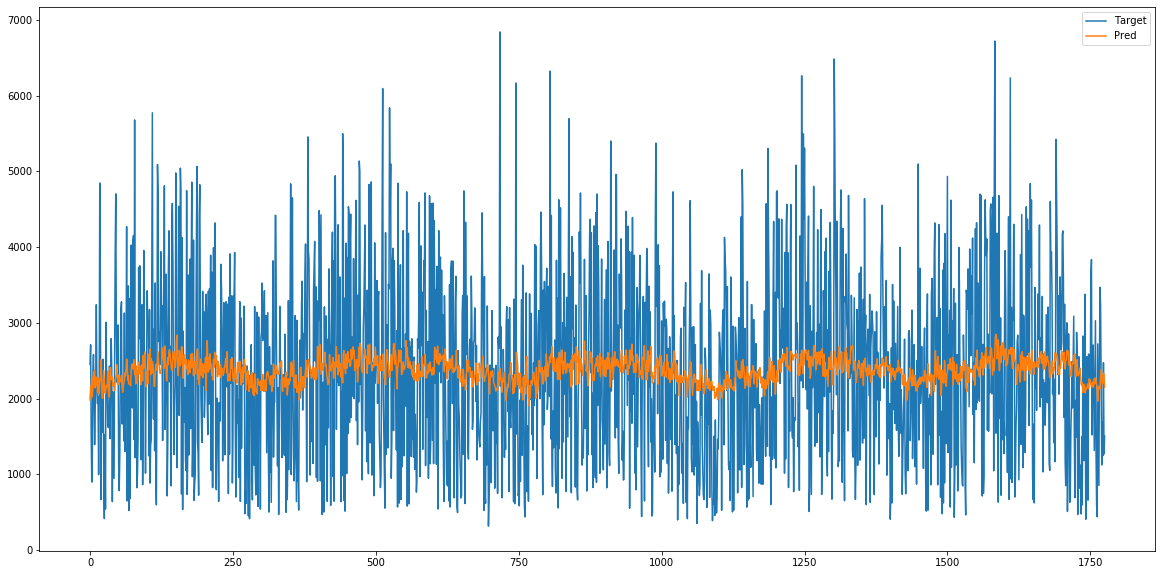

In [405]:
from sklearn.linear_model import BayesianRidge
bysr = BayesianRidge(n_iter=100, compute_score=True)
# Calling the train and test method with 10 folds
train_test_kfold(bysr, global_stats_features, global_stats_target, 10)

In [406]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
LL = Lasso()
train_test_kfold(LL, global_stats_features, global_stats_target, 10)

R2 score: 0.00768
Mean squared error: 1437311.39
Mean acc score: -0.00169


R2 score: -0.77612
Mean squared error: 2572590.80
Mean acc score: -0.78977


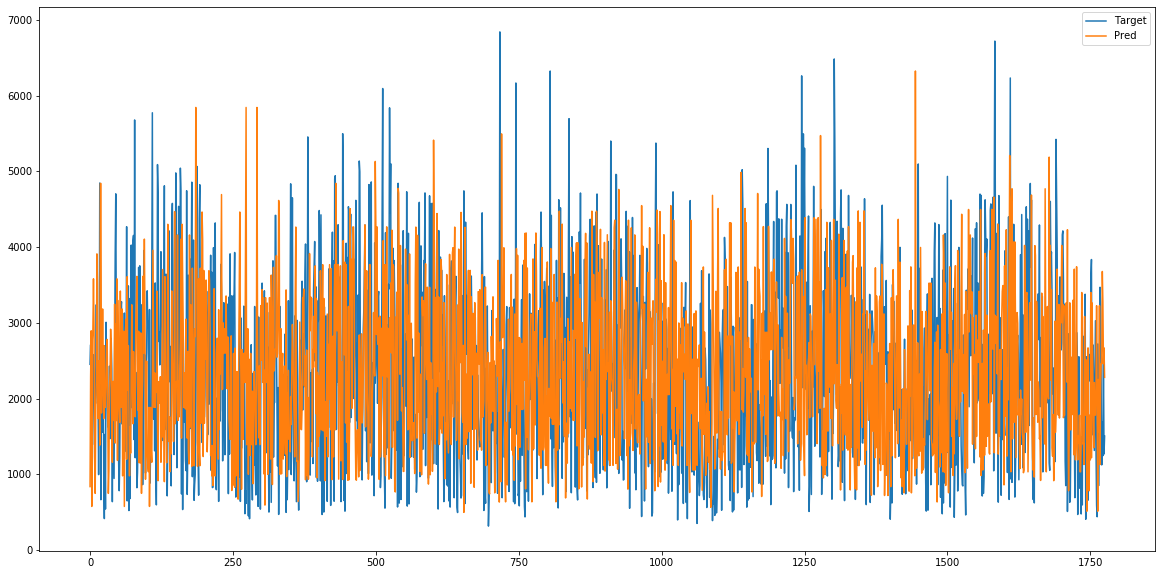

In [407]:
from sklearn.tree import DecisionTreeRegressor  
DTR = DecisionTreeRegressor(max_depth=20, min_samples_split=15) 
train_test_kfold(DTR, global_stats_features, global_stats_target, 10)

R2 score: -0.77540
Mean squared error: 2571544.37
Mean acc score: -0.78640


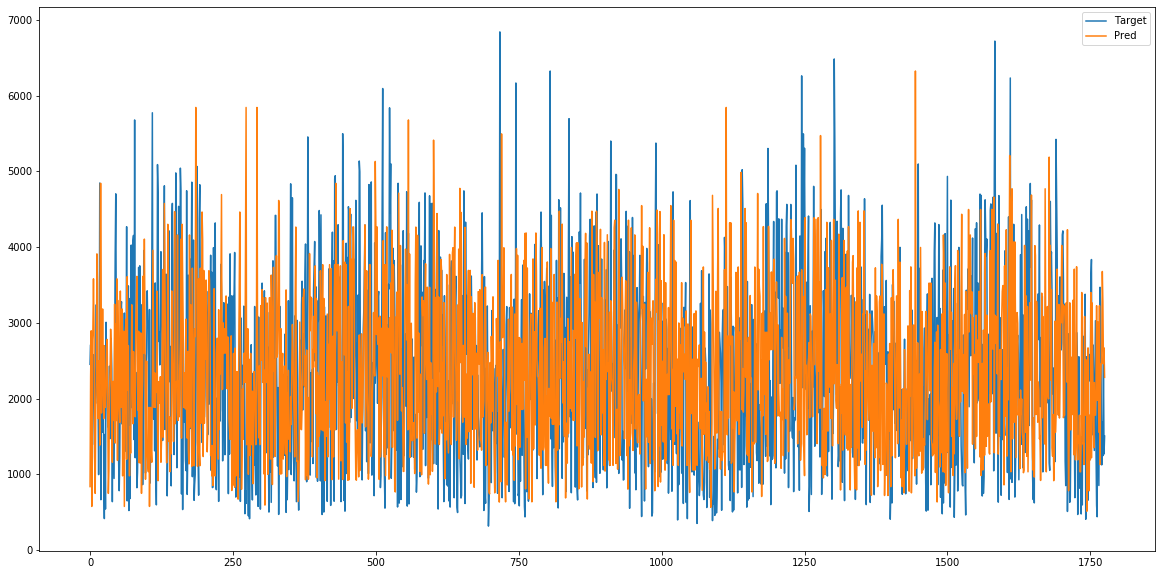

In [408]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(n_estimators=200)
train_test_kfold(DTR, global_stats_features, global_stats_target, 10)

R2 score: -0.44371
Mean squared error: 2091119.06
Mean acc score: -0.46685


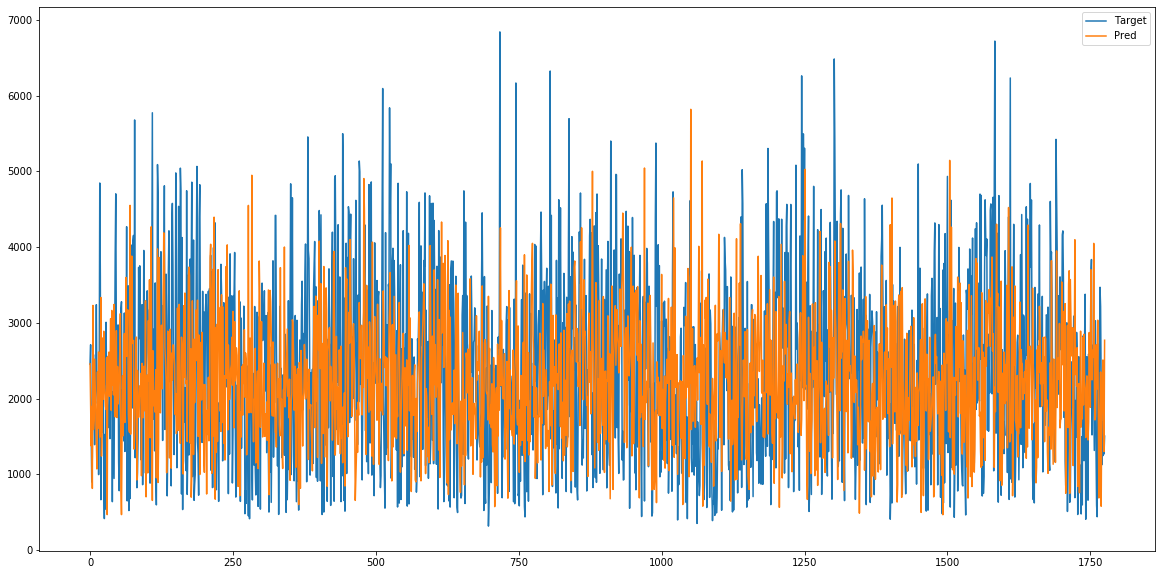

In [409]:
from sklearn import neighbors
KNN = neighbors.KNeighborsRegressor(n_neighbors = 2, weights='distance')
train_test_kfold(KNN, global_stats_features, global_stats_target, 10)

In [2]:
def test_on_returned_order(model, df, featurelist, target):
    df = df[df['ReasonOfReturn'] != -1]
    features = df[featurelist]
    target = df[target]
    target_prediction = model.predict(features)
    print(metrics.accuracy_score(target, target_prediction))
    print(np.unique(target_prediction, return_counts=True))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604981 entries, 0 to 2604980
Data columns (total 19 columns):
Customer_number           float64
Age                       float64
Gender                    int32
PoR                       object
Order_number              float64
Order_date                object
Product_number            object
Sub_category              object
Category                  object
Count                     float64
Price                     float64
Expected_delivery_time    float64
Actual_delivery_time      float64
Reason_of_return          object
Rating                    float64
order_total               float64
Product_number_numeric    object
Returned                  bool
ReasonOfReturn            float64
dtypes: bool(1), float64(10), int32(1), object(7)
memory usage: 350.3+ MB


In [4]:
df.isnull().sum()

Customer_number           1
Age                       1
Gender                    0
PoR                       1
Order_number              1
Order_date                1
Product_number            1
Sub_category              1
Category                  1
Count                     1
Price                     1
Expected_delivery_time    1
Actual_delivery_time      1
Reason_of_return          0
Rating                    1
order_total               1
Product_number_numeric    1
Returned                  0
ReasonOfReturn            0
dtype: int64

In [5]:
df.count()

Customer_number           2604980
Age                       2604980
Gender                    2604981
PoR                       2604980
Order_number              2604980
Order_date                2604980
Product_number            2604980
Sub_category              2604980
Category                  2604980
Count                     2604980
Price                     2604980
Expected_delivery_time    2604980
Actual_delivery_time      2604980
Reason_of_return          2604981
Rating                    2604980
order_total               2604980
Product_number_numeric    2604980
Returned                  2604981
ReasonOfReturn            2604981
dtype: int64

In [416]:
df[(df["Actual_delivery_time"] == -1) & (df["Reason_of_return"] == 0)]

Customer_number   Age  Gender                  PoR  Order_number  \
166            1013939.0  42.0       0            Lingewaal      119575.0   
437            1057313.0  46.0       0               Almere     1685946.0   
532            1026233.0  42.0       0     's-Hertogenbosch      111984.0   
629            1058881.0  43.0       0          Berg en Dal     1728385.0   
685            1075567.0  40.0       0  Utrechtse Heuvelrug     1647893.0   
...                  ...   ...     ...                  ...           ...   
2604548        1028466.0  30.0       1       Smallingerland      819580.0   
2604575        1040108.0  34.0       0                Texel     1471786.0   
2604758        1054594.0  40.0       1       Hollands Kroon     1540276.0   
2604785        1067960.0  82.0       0                Hoorn      210862.0   
2604935        1061780.0  36.0       0        Franekeradeel     1682675.0   

        Order_date Product_number        Sub_category           Category  \
166     2013-08-30  3136462020663       Garden chairs   Garden furniture   
437     2017-04-30  5133943231394  Insects and vermin            Control   
532     2013-08-14  1146225170575           Sunshades     Sun protection   
629     2017-07-31  3163823030191         Garden sets   Garden furniture   
685     2017-02-17  3152405161163        Lounge sofas   Lounge furniture   
...            ...            ...                 ...                ...   
2604548 2017-07-16  5109773109851             Torches     Garden heating   
2604575 2016-03-26  7105772065240       Garden tables   Garden furniture   
2604758 2016-05-08  6120914279126               Pumps           Watering   
2604785 2014-08-03  7127056188636      Garden statues  Garden decoration   
2604935 2017-04-20  2174550138839         Party tents     Sun protection   

         Count    Price  Expected_delivery_time  Actual_delivery_time  \
166        1.0   846.23                     1.0                  -1.0   
437        1.0   104.25                     1.0                  -1.0   
532        1.0   479.09                     1.0                  -1.0   
629        1.0   966.57                     3.0                  -1.0   
685        1.0   438.45                     3.0                  -1.0   
...        ...      ...                     ...                   ...   
2604548    5.0   345.50                     2.0                  -1.0   
2604575    1.0  1082.56                     1.0                  -1.0   
2604758    1.0   706.65                     1.0                  -1.0   
2604785    1.0   415.10                     4.0                  -1.0   
2604935    1.0  1022.64                     2.0                  -1.0   

        Reason_of_return  Rating  order_total Product_number_numeric  \
166                    0    -1.0       846.23          3136462020663   
437                    0     3.0       104.25          5133943231394   
532                    0     1.0       479.09          1146225170575   
629                    0    -1.0       966.57          3163823030191   
685                    0     3.0       438.45          3152405161163   
...                  ...     ...          ...                    ...   
2604548                0    -1.0      1727.50          5109773109851   
2604575                0    -1.0      1082.56          7105772065240   
2604758                0    -1.0       706.65          6120914279126   
2604785                0    -1.0       415.10          7127056188636   
2604935                0    -1.0      1022.64          2174550138839   

         Returned  ReasonOfReturn  
166         False            -1.0  
437         False            -1.0  
532         False            -1.0  
629         False            -1.0  
685         False            -1.0  
...           ...             ...  
2604548     False            -1.0  
2604575     False            -1.0  
2604758     False            -1.0  
2604785     False            -1.0  
2604935     False            -1.0

In [417]:
df = df.dropna()

In [433]:
df['Delivery_Diff'] = (df.Expected_delivery_time - df.Actual_delivery_time)
df['AVG_PRODUCT_DELDIFF'] = df.groupby(['Product_number'])['Delivery_Diff'].transform('mean')
df['AVG_POR_DELDIFF'] = df.groupby(['PoR'])['Delivery_Diff'].transform('mean')

df['AVG_ACTUAL_PRODUCT_DEL'] = df.groupby(['Product_number'])['Actual_delivery_time'].transform('mean')
df['AVG_ACTUAL_POR_DEL'] = df.groupby(['PoR'])['Actual_delivery_time'].transform('mean')
df['count_orders'] = df.groupby(['PoR'])['Actual_delivery_time'].transform('count')

C:\Users\ovelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ovelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ovelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [434]:
df.head()

Customer_number   Age  Gender                 PoR  Order_number Order_date  \
0        1049989.0  50.0       0  Goeree-Overflakkee      554370.0 2016-01-15   
1        1068587.0  49.0       0           Terneuzen     1146785.0 2014-05-16   
2        1026863.0  47.0       0      Sittard-Geleen     1146785.0 2014-05-14   
3        1049989.0  50.0       0  Goeree-Overflakkee      554370.0 2016-01-15   
4        1026863.0  47.0       0      Sittard-Geleen     1146785.0 2014-05-14   

  Product_number    Sub_category           Category  Count  ...  \
0  4174149044532   Garden tables   Garden furniture    1.0  ...   
1  7167356147773  Garden statues  Garden decoration    1.0  ...   
2  4112354045616     Garden sets   Garden furniture    1.0  ...   
3  3163858019499     Garden sets   Garden furniture    1.0  ...   
4  5122714091664           Rakes  Garden hand tools    2.0  ...   

   Product_number_numeric  Returned  ReasonOfReturn Delivery_Diff  \
0           4174149044532     False            -1.0           0.0   
1           7167356147773     False            -1.0           0.0   
2           4112354045616     False            -1.0          -3.0   
3           3163858019499     False            -1.0          -5.0   
4           5122714091664      True             0.0           9.0   

   AVG_PRODUCT_DELDIFF  AVG_POR_DELDIFF AVG_ACTUAL_PRODUCT_DEL  \
0            -0.299363        -0.686292               3.624204   
1            -0.898551        -0.749514               3.115942   
2            -0.684783        -0.652628               2.869565   
3            -0.818182        -0.686292               3.818182   
4            -0.647887        -0.652628               4.957746   

   AVG_ACTUAL_POR_DEL  PoREnc  count_orders  
0            3.399048     116         20178  
1            3.485427     309         18528  
2            3.431779     291          5746  
3            3.399048     116         20178  
4            3.431779     291          5746  

[5 rows x 26 columns]

In [435]:
df.ReasonOfReturn.unique()

array([-1.,  0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [436]:
df_lite = df.sample(frac=0.5)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['PoREnc'] = le.fit_transform(df['PoR'].astype(str))

C:\Users\ovelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [437]:
feature_list = [
    'Customer_number'
    ,'Age'
    ,'Gender'
#     ,'Order_number'
    ,'Count'
    ,'Price'
    ,'order_total'
    ,'Product_number_numeric'
    ,'count_orders'
    ,'PoREnc'
#     ,'PoR'
]
X = df[feature_list]
y = df.Actual_delivery_time
# X = pd.get_dummies(X, columns=['PoR'])
X.head(5)

Customer_number   Age  Gender  Count    Price  order_total  \
0        1049989.0  50.0       0    1.0   366.90       366.90   
1        1068587.0  49.0       0    1.0   493.95       493.95   
2        1026863.0  47.0       0    1.0   234.74       234.74   
3        1049989.0  50.0       0    1.0  1436.62      1436.62   
4        1026863.0  47.0       0    2.0    57.40       114.80   

  Product_number_numeric  count_orders  PoREnc  
0          4174149044532         20178     116  
1          7167356147773         18528     309  
2          4112354045616          5746     291  
3          3163858019499         20178     116  
4          5122714091664          5746     291

In [421]:
#X_dummy.count()

In [438]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, ytest = train_test_split(X,y, test_size = 0.2)

# from sklearn.preprocessing import scale
# X_train=scale(X_train)
# X_test=scale(X_test)

In [439]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

def train_test_kfold(model, features, target, amount_of_splits):
    kf = KFold(n_splits=amount_of_splits)
    cvs = cross_val_score(model, features, target, cv=kf)
    pred = cross_val_predict(model, features, target, cv=kf)
    print('Accuracy is: %.5f' % metrics.accuracy_score(target, pred));

In [424]:
# Decision tree
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [425]:
clf = RandomForestClassifier(n_estimators=100, random_state=0,
max_depth=50, min_samples_split=50,min_samples_leaf=300,max_leaf_nodes=1500)
clf.fit(X_train, y_train) 
RFy_pred = clf.predict(X_test)
print("Accuracy is ", metrics.accuracy_score(ytest,RFy_pred)*100)

KeyboardInterrupt: 

In [440]:
from sklearn.metrics import r2_score
clf_entropy = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=10)
#clf_entropy = tree.DecisionTreeRegressor(max_depth=10, min_samples_split=10)
clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)
print("Accuracy is ", metrics.accuracy_score(ytest,y_pred)*100)
#print("R2: ", r2_score(ytest,y_pred))

Accuracy is  26.983700450675247


In [427]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(multi_class='ovr',solver='newton-cg').fit(X_train, y_train)
LRy_pred = LR.predict(X_test)
print("Accuracy is ", metrics.accuracy_score(ytest,LRy_pred)*100)

C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\ovelk\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

KeyboardInterrupt: 

C:\Users\ovelk\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.03303e-26): result may not be accurate.
  overwrite_a=True).T


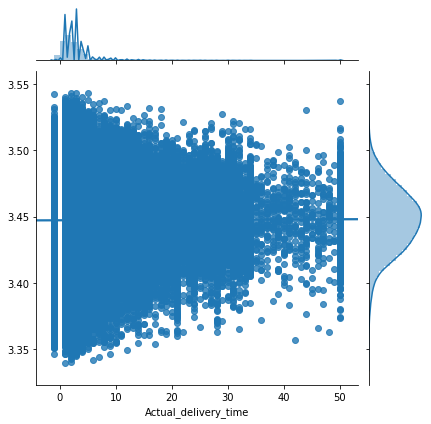

In [445]:
from sklearn.linear_model import Ridge
RR = Ridge()
RR.fit(X_train,y_train)
y_pred = RR.predict(X_test)
r2_score(ytest, y_pred)
sns.jointplot(ytest, y_pred, kind="reg")

C:\Users\ovelk\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.03303e-26): result may not be accurate.
  overwrite_a=True).T


Accuracy is  26.072944897849503


C:\Users\ovelk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ovelk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


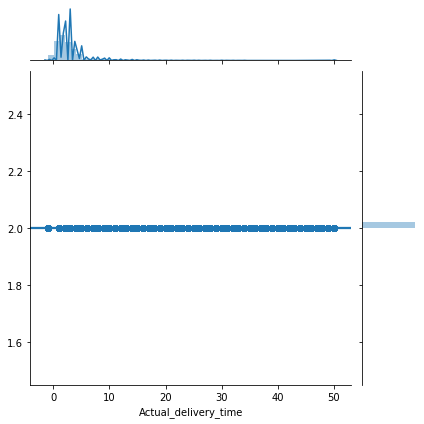

In [444]:
from sklearn.linear_model import RidgeClassifier
RC = RidgeClassifier().fit(X_train, y_train)
RCy_pred = RC.predict(X_test)
print("Accuracy is ", metrics.accuracy_score(ytest,RCy_pred)*100)
import seaborn as sns
sns.jointplot(ytest, RCy_pred, kind="reg")

In [93]:
feature_list = [
    'Customer_number'
    ,'Age'
    ,'Gender'
#     ,'Order_number'
    ,'Count'
    ,'Price'
#     ,'order_total'
    ,'Product_number_numeric'
#     ,'PoREnc'
#     ,'Delivery_Diff'
#     ,'PoR'
]
X = df[feature_list]
y = df.Returned
# X = pd.get_dummies(X, columns=['PoR'])
X.head(5)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, ytest = train_test_split(X,y, test_size = 0.2)

In [24]:
RR = Ridge()
RR.fit(X_train,y_train)
y_pred = RR.predict(X_test)
r2_score(ytest, y_pred)

C:\Users\ovelk\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.02916e-26): result may not be accurate.
  overwrite_a=True).T


-3.1917667218106516e-06

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
LL = Lasso()
LL.fit(X_train,y_train)
y_pred = LL.predict(X_test)
r2_score(ytest, y_pred)

-4.8627184259242284e-06

In [32]:
ytest

1731390     1.0
2186736    30.0
2275160     2.0
2537839     2.0
955028      2.0
           ... 
1395825     4.0
1303901     3.0
1189459     2.0
550439      1.0
2479113     3.0
Name: Actual_delivery_time, Length: 520996, dtype: float64

In [90]:
clf_entropy = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=10)
clf_entropy.fit(X_train, y_train)
test_on_returned_order(clf_entropy, df, feature_list, 'Returned')

0.0006012991225779909
(array([False,  True]), array([126317,     76], dtype=int64))


In [91]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)
test_on_returned_order(clf, df, feature_list, 'Returned')

C:\Users\ovelk\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.0
(array([False]), array([126393], dtype=int64))


In [46]:
testresult

4          0.0
6          1.0
40         2.0
99         2.0
100        0.0
          ... 
2604903    0.0
2604941    6.0
2604951    6.0
2604953    9.0
2604966    6.0
Name: ReasonOfReturn, Length: 126393, dtype: float64

In [62]:
clf = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=10)
train_test_kfold(clf, X, y, 5)

Accuracy is: 0.95148


In [33]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
train_test_kfold(gnb, X, y, 5)

Accuracy is: 0.95148


In [94]:
y_reason = df.ReasonOfReturn
train_test_kfold(clf, X_dummy, y_reason, 5)

Accuracy is: 0.95146


In [98]:
y_reason = df.ReasonOfReturn
train_test_kfold(clf, X_feat, y_reason, 5)

Accuracy is: 0.95145


In [144]:
clf_entropy = tree.DecisionTreeClassifier(max_depth=10, min_samples_split=10)
clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
y_reason = df.ReasonOfReturn
train_test_kfold(clf, X_feat, y_reason, 5)

In [142]:
ytest

798310     -1.0
651374     -1.0
453548     10.0
552670     -1.0
858157     -1.0
           ... 
401302      9.0
1146333    -1.0
1847932    -1.0
1788198    -1.0
183270     -1.0
Name: ReasonOfReturn, Length: 520996, dtype: float64

In [148]:
np.unique(y_pred)

array([-1.,  0.,  2.,  3.,  5.,  6.,  7.])

In [130]:
print(list(prob_per_class_dictionary))

[False, True]


-1.679520465304202e+20

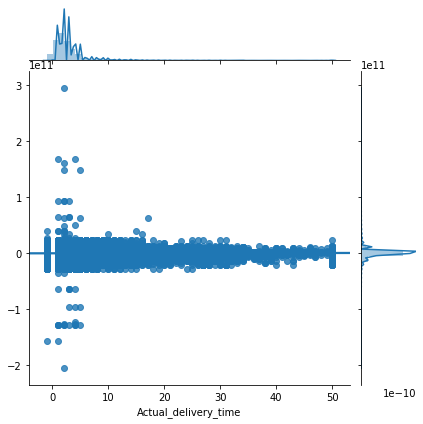

In [54]:
import sklearn.metrics
regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
sns.jointplot(ytest, y_pred, kind="reg")
r2_score(ytest, y_pred)*100

In [29]:
importances=clf_entropy.feature_importances_
importances=pd.DataFrame([X.columns,importances]).transpose()
importances.columns=[['Variables','Importance']]
importances

Variables   Importance
0                        Customer_number   0.00494647
1                                    Age   0.00276937
2                                 Gender  0.000568592
3                           Order_number     0.005112
4                                  Count  0.000259234
5                                  Price   0.00236165
6                 Expected_delivery_time     0.979616
7                            order_total   0.00261663
8                      PoR_'s-Gravenhage            0
9                   PoR_'s-Hertogenbosch  4.18721e-05
10                       PoR_Aa en Hunze            0
11                           PoR_Aalburg            0
12                          PoR_Aalsmeer            0
13                            PoR_Aalten            0
14                     PoR_Achtkarspelen            0
15                      PoR_Alblasserdam            0
16                     PoR_Albrandswaard            0
17                           PoR_Alkmaar            0
18                            PoR_Almelo  7.89519e-06
19                            PoR_Almere            0
20               PoR_Alphen aan den Rijn            0
21                      PoR_Alphen-Chaam            0
22                           PoR_Ameland            0
23                        PoR_Amersfoort            0
24                        PoR_Amstelveen            0
25                         PoR_Amsterdam  2.13663e-05
26                         PoR_Apeldoorn  1.11282e-05
27                        PoR_Appingedam            0
28                            PoR_Arnhem            0
29                             PoR_Assen            0
..                                   ...          ...
465             Sub_category_Split forks            0
466    Sub_category_Split forks (2-pack)            0
467              Sub_category_Sprinklers  2.08289e-05
468     Sub_category_Sprinklers (2-pack)            0
469                Sub_category_Sun beds            0
470       Sub_category_Sun beds (2-pack)            0
471                Sub_category_Sundials            0
472               Sub_category_Sunshades  3.55703e-05
473      Sub_category_Sunshades (2-pack)            0
474                 Sub_category_Torches            0
475        Sub_category_Torches (2-pack)            0
476              Sub_category_Weed brush            0
477     Sub_category_Weed brush (2-pack)            0
478             Sub_category_Weed burner            0
479    Sub_category_Weed burner (2-pack)            0
480           Sub_category_Wheelbarrrows            0
481  Sub_category_Wheelbarrrows (2-pack)            0
482                      Sub_category_\             0
483                     Category_Control  5.15563e-05
484           Category_Garden decoration            0
485            Category_Garden furniture  0.000370974
486           Category_Garden hand tools            0
487              Category_Garden heating   3.8076e-05
488              Category_Garden reamers  5.76792e-05
489             Category_Gardening tools            0
490            Category_Lounge furniture  4.48755e-05
491             Category_Other furniture    1.483e-05
492                     Category_Pruning            0
493              Category_Sun protection  7.98836e-05
494                    Category_Watering  6.35315e-05

[495 rows x 2 columns]

In [55]:
#Random tree
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=80)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print("Accuracy is ", metrics.accuracy_score(ytest,y_pred)*100)

Accuracy is  58.286435980314636


In [11]:
#Fitting Multiple Linear Regression to Training set
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

y_pred
# import statsmodels.api as sm
# X = np.append(arr = np.ones((X.size-1,1)).astype(int), values= X, axis = 1)
# X_opt = X
# regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
# regressor_OLS.summary()

array([3.31155447, 3.38506292, 3.92689162, ..., 3.46210676, 3.56191274,
       2.85694758])

In [12]:
from sklearn.metrics import mean_squared_error,r2_score
mean_squared_error(ytest, y_pred)

19.73788347467437

In [13]:
r2_score(ytest, y_pred)

0.0007755626832528506

In [14]:
ytest

909418     1.0
2304074    1.0
137491     1.0
595456     4.0
1174259    4.0
          ... 
542205     2.0
1785779    1.0
2424513   -1.0
2513957    3.0
2014851    2.0
Name: Actual_delivery_time, Length: 260498, dtype: float64

In [66]:
df.Product_number.value_counts()

6190683069891    293
3190288214989    289
3181700099147    288
2182938227969    283
3172357254683    282
                ... 
ll88ll3l5965l      1
711O641O52O3O      1
7l70902273864      1
6123436241O6O      1
514OO45O75153      1
Name: Product_number, Length: 23312, dtype: int64